In [1]:
using CausalForest
using StatsBase
using Plots
using Random
using Distributions
using RCall
using BenchmarkTools
using DelimitedFiles

In [2]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 1

1

In [3]:
Random.seed!(123);
n, m = 10^4, 10;
u = Uniform(0,10);
features = rand(u, (n, m));
X = features;
d = Normal();
eps = rand(d, n);
b = Bernoulli();
T = convert(Vector{Int64},rand(b, n));
Y = sin.(features*[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]).*T  + features*[0, 0, 2, 0, 0, 0, 3, 0, 0, 0];

In [4]:
df = hcat(X,T,Y)

10000×12 Matrix{Float64}:
 9.063     0.273863  9.2398     …  8.02953    8.61508   1.0  32.7318
 4.43494   8.65398   4.38668       4.26558    5.79587   0.0  10.2415
 7.45673   7.98071   9.35901       7.38559    9.99516   0.0  27.5137
 5.12083   8.25448   8.79223       0.835565   8.06585   0.0  24.796
 2.53849   5.30423   5.84012       0.570453   9.6668    0.0  22.6625
 3.34152   2.66141   9.8669     …  0.92876    9.49805   1.0  25.1241
 4.27328   8.75436   0.0258112     5.12688    2.24987   1.0   8.09666
 8.67547   7.27313   0.151025      0.0873517  0.765286  0.0  25.0373
 0.991336  1.20752   5.87184       8.38971    9.81301   0.0  20.8175
 1.25287   6.88003   3.64868       4.16181    3.00126   0.0  26.2578
 6.92209   0.298644  4.84843    …  8.07655    1.49476   0.0  36.4211
 1.36551   1.07227   0.570038      2.53062    7.60498   1.0  21.9686
 0.320967  6.45858   4.85281       9.74512    1.98433   0.0  32.6943
 ⋮                              ⋱                       ⋮    
 1.41477   4.12

In [5]:
#header = ["X1" "X2" "X3" "X4" "X5" "X6" "X7" "X8" "X9" "X10" "T" "Y"]
#writedlm("sinus_causal_3.csv", [header ; df], ",")

In [6]:
reval("set.seed(1)")
Xtest_1 = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
true_effect_1 = sin.(Xtest_1[:, 1]);

In [7]:
function get_all_nodes_in_tree!(
    tree ,
    depth = 3,
    result  = []
    )
    if hasproperty(tree, :featid) && depth > 0
        push!(result, tree.featid)
        get_all_nodes_in_tree!(tree.left, depth-1, result)
        get_all_nodes_in_tree!(tree.right, depth-1, result)
    end
    return result
end

function get_freq(forest, depth=3) 
    ensemble = forest.trees
    n_trees = length(ensemble)
    res = []
    for i = 1:n_trees
        append!(res, get_all_nodes_in_tree!(forest.trees[i].tree, depth))
    end
    return proportionmap(res)
end

get_freq (generic function with 2 methods)

# Critère nouveau

### Subsampling

In [8]:
errors_11 = zeros(100)

cf = @btime build_forest(false, true, Y, T, X, true, 10, 500, 500)
pred = @btime apply_forest(cf, Xtest_1)
errors_11[1] = rmsd(float(true_effect_1), pred)
for i in 2:100
    @rput i
    reval("set.seed(i)")
    Xtest = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
    pred = apply_forest(cf, Xtest)
    true_effect = sin.(Xtest[:, 1])
    errors_11[i] = rmsd(float(true_effect), pred)
end
println(mean(errors_11))
println(var(errors_11))

  354.281 s (144078132 allocations: 20.00 GiB)
  3.889 s (128307254 allocations: 2.37 GiB)
0.03681291914448504
8.638601530872648e-7


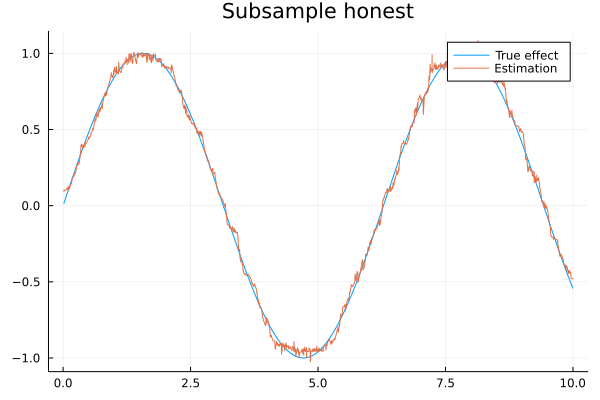

In [9]:
ind = sortperm(Xtest_1[:, 1])
pred = apply_forest(cf, Xtest_1)
plot(Xtest_1[ind, 1], [true_effect_1[ind], pred[ind]], label=["True effect" "Estimation"], title = "Subsample honest", fmt = :png)

In [10]:
get_freq(cf, 3)

Dict{Any, Float64} with 1 entry:
  1 => 1.0

In [11]:
get_freq(cf, 5)

Dict{Any, Float64} with 10 entries:
  5  => 0.0323035
  4  => 0.0301588
  6  => 0.0314322
  7  => 0.0365927
  2  => 0.0260706
  10 => 0.0276791
  9  => 0.0293546
  8  => 0.0361236
  3  => 0.0402788
  1  => 0.710006

In [12]:
get_freq(cf, 10)

Dict{Any, Float64} with 10 entries:
  5  => 0.0781646
  4  => 0.0790435
  6  => 0.0829548
  7  => 0.0957904
  2  => 0.0793405
  10 => 0.0764318
  9  => 0.0760976
  8  => 0.082274
  3  => 0.0922628
  1  => 0.25764

### Bootstrap

In [13]:
errors_12 = zeros(100)

cf = @btime build_forest(true, true, Y, T, X, true, 10, 500, 500)
pred = @btime apply_forest(cf, Xtest_1)
errors_12[1] = rmsd(float(true_effect_1), pred)
for i in 2:100
    @rput i
    
    reval("set.seed(i)")
    Xtest = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
    pred = apply_forest(cf, Xtest)
    true_effect = sin.(Xtest[:, 1])
    errors_12[i] = rmsd(float(true_effect), pred)
end
println(mean(errors_12))
println(var(errors_12))

  215.169 s (145224538 allocations: 20.19 GiB)
  4.232 s (138032756 allocations: 2.52 GiB)
0.03897636059793175
7.306411835558929e-7


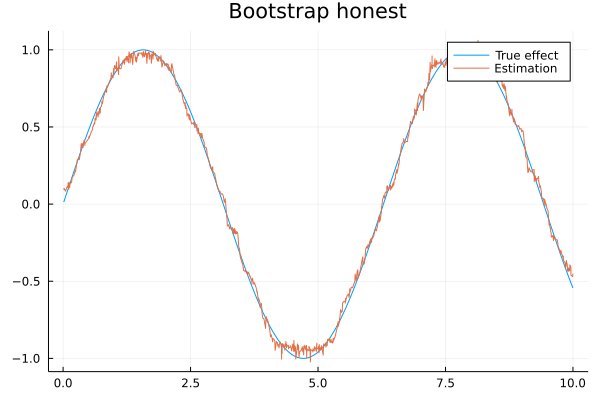

In [14]:
ind = sortperm(Xtest_1[:, 1])
pred = apply_forest(cf, Xtest_1)
plot(Xtest_1[ind, 1], [true_effect_1[ind], pred[ind]], label=["True effect" "Estimation"], title = "Bootstrap honest", fmt = :png)

In [15]:
get_freq(cf, 3)

Dict{Any, Float64} with 5 entries:
  6 => 0.000285714
  7 => 0.000285714
  9 => 0.000285714
  3 => 0.00228571
  1 => 0.996857

In [16]:
get_freq(cf, 5)

Dict{Any, Float64} with 10 entries:
  5  => 0.0345452
  4  => 0.0301181
  6  => 0.0370942
  7  => 0.0448082
  2  => 0.031795
  10 => 0.0307888
  9  => 0.0363563
  8  => 0.0325329
  3  => 0.0552723
  1  => 0.666689

In [17]:
get_freq(cf, 10)

Dict{Any, Float64} with 10 entries:
  5  => 0.0833465
  4  => 0.080492
  6  => 0.0867361
  7  => 0.0986578
  2  => 0.0840811
  10 => 0.0799358
  9  => 0.0819507
  8  => 0.0830421
  3  => 0.0985948
  1  => 0.223163